```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Comparing dam break benchmark from SWASHES

#### Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


import os
import pyopencl
import datetime
import sys

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
if (str.lower(sys.platform).startswith("linux")):
    os.environ["PYOPENCL_CTX"] = "0"
else:
    os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce GTX 780


In [3]:
#Create output directory for images
imgdir='images_swashes_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print "Saving images to " + imgdir

Saving images to images_swashes_2018_04_06-14_44_15


## Swashes dam break parameters - Case 4.1.1

We use a 1D domain consisting, meaning ny = 1.

3.67116592458 4.81668339024 6.25978040052


(-0.1, 0.17)

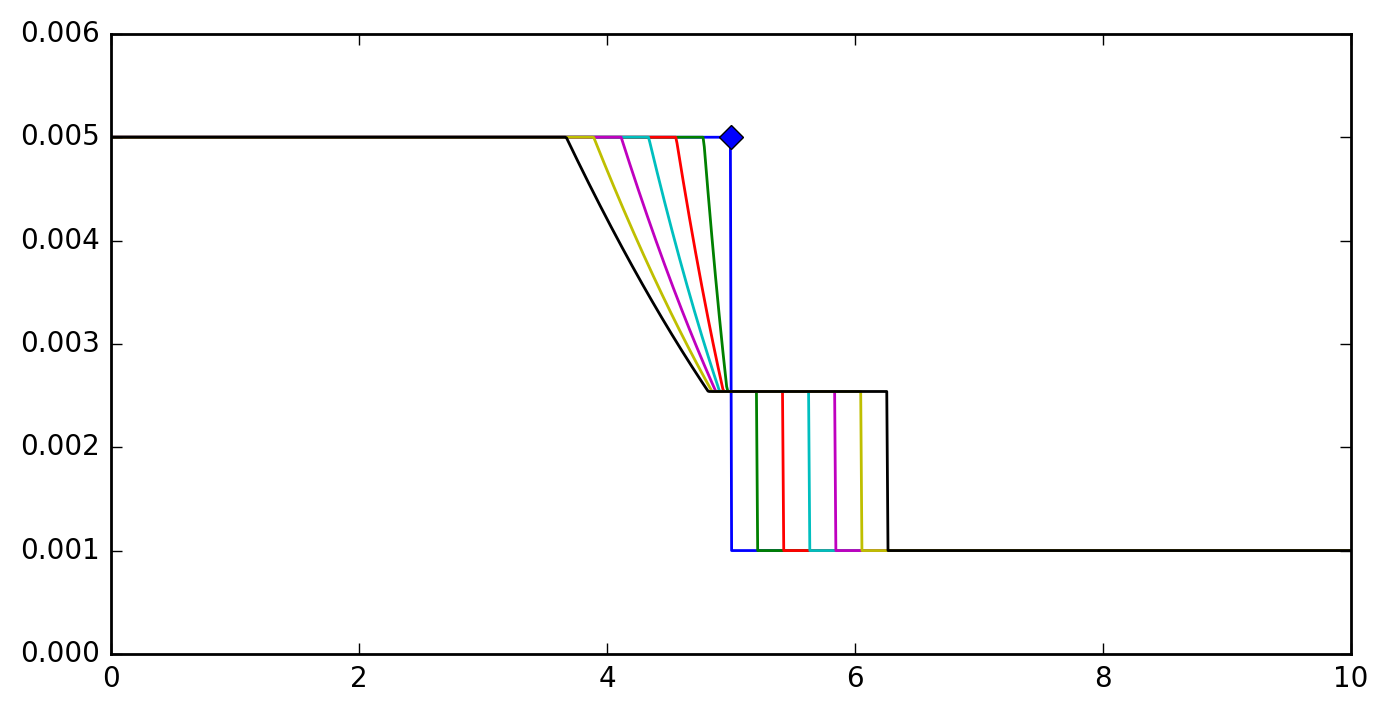

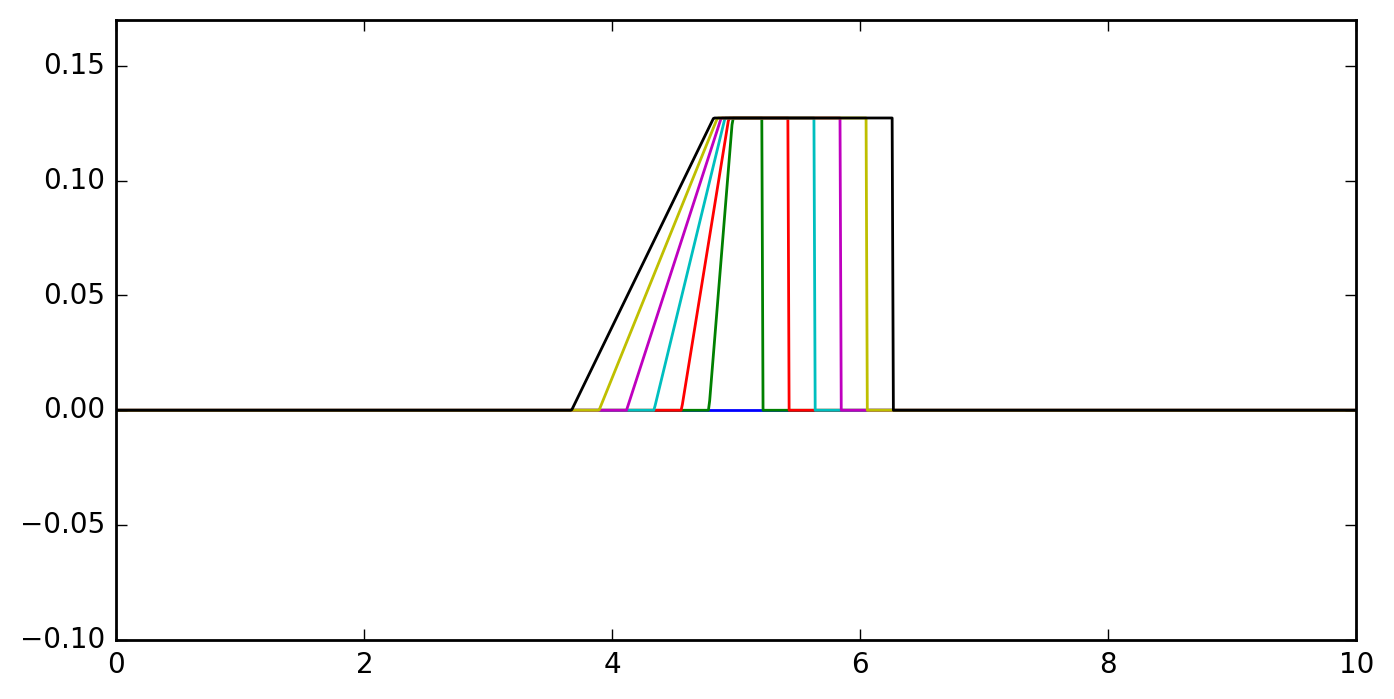

In [4]:
# Plot analytic solution
x0 = 5.0
L = 10.0
g = 9.81
hr = 0.001
hl = 0.005
eta_equilibrium = 0.003
mult_T = [0,1,2,3,4,5,6]
cm = 0.1578324867 # dependent of g, hr, hl

def xA(t, x0):
    return x0 - t*np.sqrt(g*hl)
def xB(t, x0):
    return x0 + t*(2*np.sqrt(g*hl) - 3*cm)
def xC(t, x0):
    return x0 + t*(2*cm**2 *(np.sqrt(g*hl) - cm))/(cm**2 - g*hr)

def h_rarefaction(t, x0, x):
    h =(4.0/(9.0*g))* (np.sqrt(g*hl) - (x - x0)/(2*t))**2
    u = (2.0/3.0)*((x-x0)/t + np.sqrt(g*hl))
    return h, u
    
def swashes_h(t, x0, x_array):
    h = np.zeros_like(x_array)
    u = np.zeros_like(x_array)
    N = len(x_array)
    x_a = xA(t, x0)
    x_b = xB(t, x0)
    x_c = xC(t, x0)
    for i in range(N):
        x = x_array[i]
        if x < x_a:
            h[i] = hl
        elif x < x_b:
            h[i], u[i] = h_rarefaction(t, x0, x)
        elif x < x_c:
            h[i] = cm*cm/g
            u[i] = 2*(np.sqrt(g*hl)  - cm)
        else:
            h[i] = hr
    return h, u

"""
Generates initial conditions for x-directional dam break at x0, 
and high level is given by hl, and low level by hr.
"""
def make1DSwashes(h, nx, ny, dx, dy, halo, x0, hl, hr):
    for j in range(0, ny+halo[0]+halo[2]):
        y = (j-halo[2])*dy
        for i in range(0, nx+halo[1]+halo[3]):
            x = (i-halo[3])*dx
            if ( x < x0):
                h[j,i] = hl
            else:
                h[j,i] = hr

# Plotting analaytic solutions to test the above functions
x_array = np.linspace(0,10.0,num=1000)
x_a = xA(6.0, x0)
x_b = xB(6.0, x0)
x_c = xC(6.0, x0)
print x_a, x_b, x_c
fig = plt.figure(figsize=(8,4))
for t in range(7):
    h, u = swashes_h(t, x0, x_array)
    plt.plot(x_array, h)
plt.plot(x0, hl, 'D')
plt.ylim(0.0, 0.006)

fig = plt.figure(figsize=(8,4))
for t in range(7):
    h, u = swashes_h(t, x0,  x_array)
    plt.plot(x_array, u)
plt.ylim(-0.1, 0.17)

In [56]:
# Simulation parameters:

nx = 200
ny = 1
dx = L / (1.0*200)
dy = dx
print "dx: ", dx

theoretically_max_u = 0.15
max_dt = 0.25* dx/(theoretically_max_u + np.sqrt(g*hl))
print "max_dt", max_dt
dt = 0.01
T = 6.0
#T = 4.18

# parameters we don't use:
f = 0.0
r = 0.0
A = 0.0


dx:  0.05
max_dt 0.0336498803689


0.0 10.0
eta0.shape:  (5, 204)
T:  6.0
eta_ctcs.shape:  (3, 202)
min, max (eta_ctcs):  nan nan
eta_fbl.shape:  (1, 200)
min, max (eta_fbl):  -0.002 0.002
eta_fasit.shape:  200
Times (fbl, ctcs, kp07, cdklm):  6.00004 6.00004 6.00004 6.00004
swashes/case411_2018_04_06-17_37_24***.png


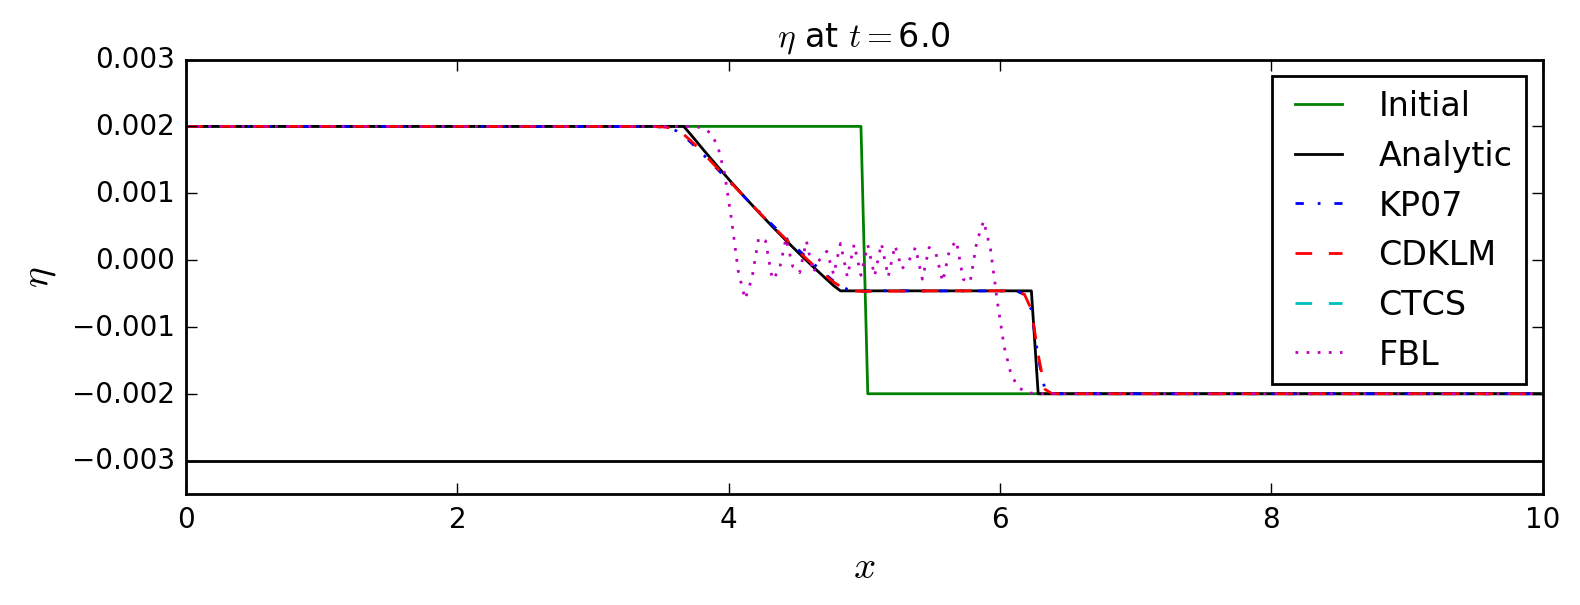

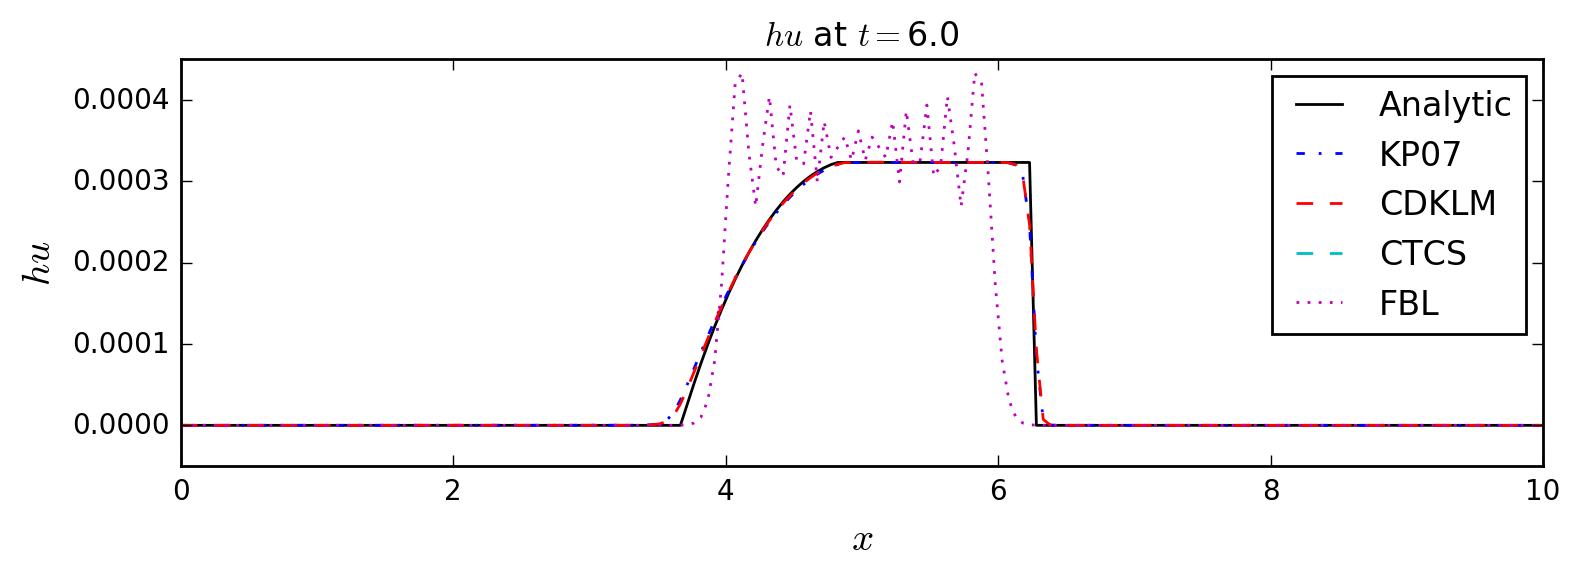

In [62]:
## Non-staggered:

x_array = np.linspace(0.0,L,num=nx)
print x_array[0], x_array[-1]

boundaryConditions = Common.BoundaryConditions()
ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])
    
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

eta0 = np.zeros(dataShape, dtype=np.float32, order='C');
print "eta0.shape: ", eta0.shape
make1DSwashes(eta0, nx, ny, dx, dy, ghosts, x0, hl, hr)
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')

print "T: ", T
# Transform case so that we use eta and H instead of h and B:
eta0 = eta0 - eta_equilibrium
Hi = Hi + eta_equilibrium


# KP07
sim = KP07.KP07(cl_ctx, \
                eta0, Hi, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, \
                boundary_conditions=boundaryConditions)

t_kp07 = sim.step(T)
eta_kp07, hu_kp07, hv_kp07 = sim.download()

# CDKLM16
sim = CDKLM16.CDKLM16(cl_ctx, \
                      eta0, u0, v0, Hi, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r, \
                      boundary_conditions=boundaryConditions)

t_cdklm = sim.step(T)
eta_cdklm, hu_cdklm, hv_cdklm = sim.download()


## Staggered CTCS
ghosts = [1,1,1,1] # north, east, south, west
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])
h0 = np.ones(dataShape, dtype=np.float32, order='C') * eta_equilibrium;
eta0_ctcs = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');    
make1DSwashes(eta0_ctcs, nx, ny, dx, dy, ghosts, x0, hl, hr)
eta0_ctcs = eta0_ctcs - eta_equilibrium
ctcs_sim = CTCS.CTCS(cl_ctx, \
                     h0, eta0_ctcs, u0, v0, \
                     nx, ny, dx, dy, dt, \
                     g, f, r, A, \
                     boundary_conditions=boundaryConditions )
#t = ctcs_sim.step(dt*370)
t_ctcs = ctcs_sim.step(T)
eta_ctcs, hu_ctcs, hv_ctcs = ctcs_sim.download()
print "eta_ctcs.shape: ", eta_ctcs.shape
print "min, max (eta_ctcs): ", np.min(eta_ctcs), np.max(eta_ctcs)


## Staggered FBL
ghosts = [0,0,0,0]
#validDomain = [None, None, 0, 0]    
boundaryConditions = Common.BoundaryConditions()
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

H0 = np.ones(dataShape, dtype=np.float32, order='C') * eta_equilibrium;
eta0_fbl = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');

make1DSwashes(eta0_fbl, nx, ny, dx, dy, ghosts, x0, hl, hr)
eta0_fbl = eta0_fbl - eta_equilibrium
fbl_sim = FBL.FBL(cl_ctx, \
                  H0, eta0_fbl, u0, v0, \
                  nx, ny, \
                  dx, dy, dt, \
                  g, f, r, \
                  boundary_conditions=boundaryConditions)
#t = ctcs_sim.step(dt*370)
t_fbl = fbl_sim.step(T)
eta_fbl, hu_fbl, hv_fbl = fbl_sim.download()
print "eta_fbl.shape: ", eta_fbl.shape
print "min, max (eta_fbl): ", np.min(eta_fbl), np.max(eta_fbl)


## Analytic solution
eta_fasit, hu_fasit = swashes_h(t_kp07, x0, x_array)
print "eta_fasit.shape: ", len(eta_fasit)

### Plotting eta

fig_eta = plt.figure(figsize=(8,3))
plt.plot(x_array, eta0[2,2:-2], "g", label="Initial")
plt.plot(x_array, eta_fasit-eta_equilibrium, 'k', label="Analytic")
plt.plot(x_array, eta_kp07[2,2:-2], "-.b", label="KP07")
plt.plot(x_array, eta_cdklm[2, 2:-2], "--r", label="CDKLM")
plt.plot(x_array, eta_ctcs[1, 1:-1], '--c', label="CTCS")
plt.plot(x_array, eta_fbl[0,:], ':m', label="FBL")
plt.plot(x_array, -H0[0,:], 'k')

#plt.plot(x_array, eta1[2,2:-2])
plt.ylim(-0.0035, 0.003)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$\eta$', fontsize=14)
plt.legend()
plt.tight_layout()
plt.title('$\eta$ at $t = $' + str(T))

print "Times (fbl, ctcs, kp07, cdklm): ", t_fbl, t_ctcs, t_kp07, t_cdklm

### Plotting hu

fig_hu = plt.figure(figsize=(8,3))
plt.plot(x_array, hu_fasit*eta_fasit, 'k', label="Analytic")
plt.plot(x_array, hu_kp07[2,2:-2], "-.b", label="KP07")
plt.plot(x_array, hu_cdklm[2, 2:-2], "--r", label="CDKLM")
plt.plot(x_array, hu_ctcs[1, 1:-2], '--c', label="CTCS")
plt.plot(x_array, hu_fbl[0,1:], ':m', label="FBL")

plt.ylim(-0.00005, 0.00045)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$hu$', fontsize=14)
plt.title('$hu$ at $t = $' + str(T))
plt.legend()
plt.tight_layout()

### Save figures
imgdir = "swashes/"
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
fig_eta.savefig(imgdir + "case411_" + timestamp + "_eta.png")
fig_hu.savefig(imgdir + "case411_" + timestamp + "_hu.png")
print imgdir + "case411_" + timestamp + "***.png"